# k-shot

## 精度が上がることは、4.4で見る。ここでは分散が小さくなることだけ確認

In [1]:
from emb_net import TaskEmbeddingNet as PENUTS
import torch

model_path = "./models_penuts/emb_epoch24500_0.0010_np_45.pt"
z_dim = 10
disable_pz = False
clip_siigma = False

emb_net = PENUTS(z_dim=z_dim, disable_layernorm_fc=True).to("cuda")
emb_net.load_state_dict(torch.load(model_path, map_location="cuda"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Normal, Freeze, Random, No-Obj, Hidden

In [2]:
ls demos/

Freeze/  Hidden50/  Hidden64/  No_Obj/  Normal/  Random/


In [3]:
test_dir = "../data/mil_data/data_mini/sim_push_test/"

In [4]:
import os
from glob import glob
from natsort import natsorted
demo_paths_normal = natsorted(glob(os.path.join("./demos_mini/Normal", "*.gif")))
demo_paths_freeze = natsorted(glob(os.path.join("./demos_mini/Freeze", "*.gif")))
demo_paths_random = natsorted(glob(os.path.join("./demos_mini/Random", "*.gif")))
demo_paths_no_obj = natsorted(glob(os.path.join("./demos_mini/No_Obj/", "*.gif")))
demo_paths_hidden64 = natsorted(glob(os.path.join("./demos_mini/Hidden64", "*.gif")))

In [5]:
demo_paths_all = {"Normal":demo_paths_normal, "Freeze":demo_paths_freeze, \
                  "Random":demo_paths_random, "No_Obj":demo_paths_no_obj, \
                  "Hidden":demo_paths_hidden64}

In [6]:
import numpy as np
from utils import vread, poe, make_emb_input
from torch.distributions import Normal

def embedding_np(demo_path, disable_pz, clip_sigma, z_dim):
    inp = make_emb_input(demo_path).to("cuda")
    
    with torch.no_grad():
        train_mu, train_logvar = torch.split(emb_net(inp), z_dim, dim=1)
    if not clip_sigma:
        train_scale = torch.exp(0.5 * train_logvar)
    else:
        train_scale = 0.1 + 0.9 * torch.sigmoid(train_logvar)
    if disable_pz:
        prior = Normal(train_mu, train_scale)
    else:
        standard_normal = Normal(torch.zeros(1, z_dim).to("cuda"), torch.ones(1, z_dim).to("cuda"))
        prior = poe(standard_normal, Normal(train_mu, train_scale), z_dim)
    # z = prior.mean
    return prior # {"mean": prior.mean.cpu().numpy()[0], "stddev":prior.stddev.cpu().numpy()[0]}

In [7]:
def add_demo(prior, demo_path, clip_sigma, z_dim):
    inp = make_emb_input(demo_path).to("cuda")
    with torch.no_grad():
        test_mu, test_logvar = torch.split(emb_net(inp), z_dim, dim=1)
    if not clip_sigma:
        test_scale = torch.exp(0.5*test_logvar)
    else:
        test_scale = 0.1 + 0.9 * torch.sigmoid(test_logvar)
    posterior = poe(prior, Normal(test_mu, test_scale), z_dim)
    return posterior

## 1回サンプリング

In [25]:
import random

z1 = []
for i in range(30):
    path = random.choice(demo_paths_normal)
    prior = embedding_np(path, disable_pz, clip_siigma, z_dim)
    z1.append(prior)

## 2回サンプリング

In [26]:
import random

z2 = []
for i in range(30):
    path = random.choice(demo_paths_normal)
    prior = embedding_np(path, disable_pz, clip_siigma, z_dim)
    path = random.choice(demo_paths_normal)
    prior = add_demo(prior, path, clip_siigma, z_dim)
    z2.append(prior)

## 3回サンプリング

In [27]:
import random

z3 = []
for i in range(30):
    path = random.choice(demo_paths_normal)
    prior = embedding_np(path, disable_pz, clip_siigma, z_dim)
    path = random.choice(demo_paths_normal)
    prior = add_demo(prior, path, clip_siigma, z_dim)
    path = random.choice(demo_paths_normal)
    prior = add_demo(prior, path, clip_siigma, z_dim)
    z3.append(prior)

## 4回サンプリング

In [28]:
import random

z4 = []
for i in range(30):
    path = random.choice(demo_paths_normal)
    prior = embedding_np(path, disable_pz, clip_siigma, z_dim)
    path = random.choice(demo_paths_normal)
    prior = add_demo(prior, path, clip_siigma, z_dim)
    path = random.choice(demo_paths_normal)
    prior = add_demo(prior, path, clip_siigma, z_dim)
    path = random.choice(demo_paths_normal)
    prior = add_demo(prior, path, clip_siigma, z_dim)
    z4.append(prior)

## 5回サンプリング

In [29]:
import random

z5 = []
for i in range(30):
    path = random.choice(demo_paths_normal)
    prior = embedding_np(path, disable_pz, clip_siigma, z_dim)
    path = random.choice(demo_paths_normal)
    prior = add_demo(prior, path, clip_siigma, z_dim)
    path = random.choice(demo_paths_normal)
    prior = add_demo(prior, path, clip_siigma, z_dim)
    path = random.choice(demo_paths_normal)
    prior = add_demo(prior, path, clip_siigma, z_dim)
    path = random.choice(demo_paths_normal)
    prior = add_demo(prior, path, clip_siigma, z_dim)
    z5.append(prior)

In [30]:
z1_std = np.array([prior.stddev.cpu().numpy()[0] for prior in z1])
z2_std = np.array([prior.stddev.cpu().numpy()[0] for prior in z2])
z3_std = np.array([prior.stddev.cpu().numpy()[0] for prior in z3])
z4_std = np.array([prior.stddev.cpu().numpy()[0] for prior in z4])
z5_std = np.array([prior.stddev.cpu().numpy()[0] for prior in z5])

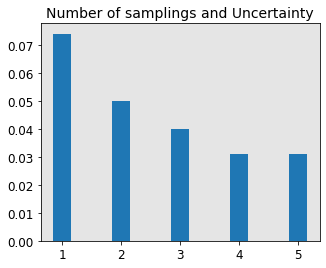

In [31]:
import matplotlib.pyplot as plt
from utils import *

fig, ax = plt_base("Number of samplings and Uncertainty", figsize=(5,4))
plt.hlines([0.7], -0.8, 5, "red", linestyles='dashed')
plt.tick_params(labelsize=12)
plt.bar(["1", "2", "3", "4", "5"], \
        [z1_std.mean(), z2_std.mean(), z3_std.mean(), z5_std.mean(), z5_std.mean()], \
        width=0.3, align="center"); plt.show()